# CIFAR10 90% test accuracy
This is notebook is a (hopefully cleaner) reimplementation of a [kaggle notebook](https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min).  
The first goal is to familiarize my self with more advanced architecture and training method than the baseline tutorial model.  
The second goal is to interpret the trained model.  

## Setup

### Imports

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader as DL
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
)

from trainer import Trainer

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Datasets, Transforms and Data loaders

### Transforms

In [3]:
CHANNELS_MEAN = (0.4914, 0.4822, 0.4465)
CHANNELS_STD = (0.2023, 0.1994, 0.2010)

training_transform = Compose([
    RandomCrop(32, padding=4, padding_mode="constant"),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])
validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

### Datasets

In [4]:
training_dataset = CIFAR10(root="./datasets/cifar10/", train=True, download=True, transform=training_transform)
validation_dataset = CIFAR10(root="./datasets/cifar10/", train=False, transform=validation_transform)

Files already downloaded and verified


### Datasets loaders

In [5]:
BATCH_SIZE = 400
training_dl = DL(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
validation_dl = DL(validation_dataset, BATCH_SIZE * 2, num_workers=3, pin_memory=True)

### Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


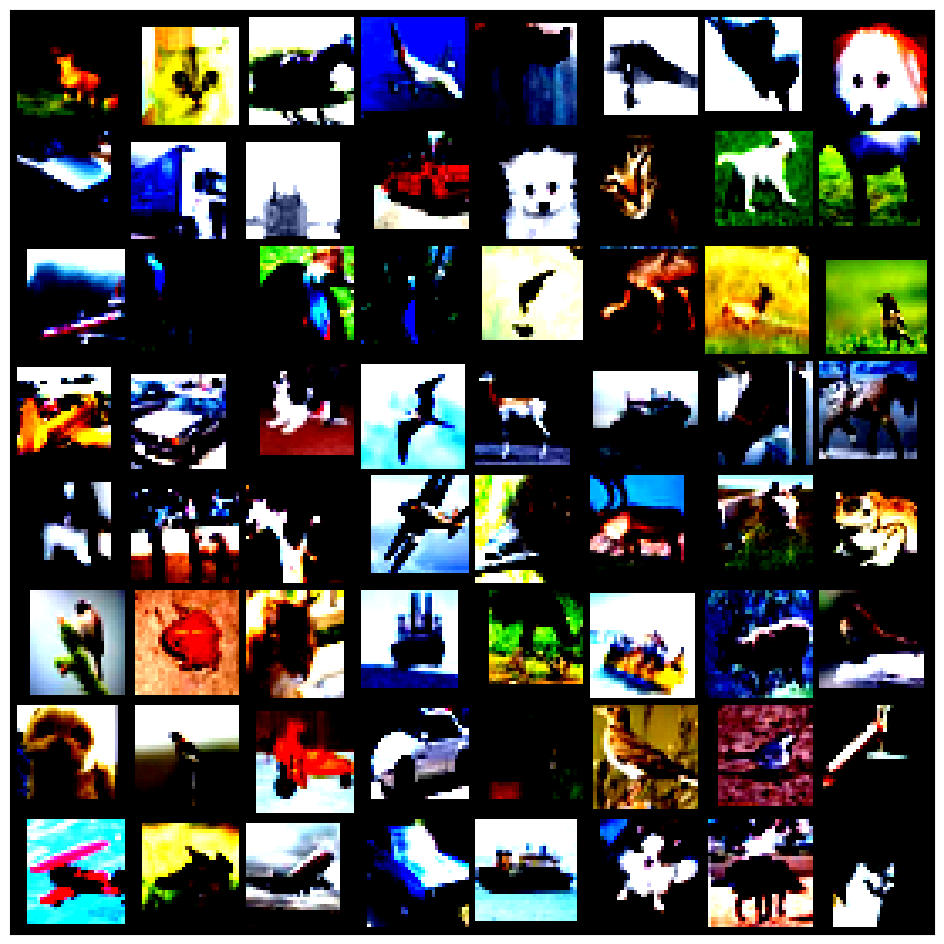

In [6]:
images, labels = next(iter(training_dl))
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

## Model definition

In [7]:
def conv_block(in_channels: int, out_channels: int, pool=False) -> nn.Module:
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
    ]
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, num_classes),
        )

        
    def forward(self, xb: Tensor) -> Tensor:
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model = ResNet9(3, 10).cuda()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [8]:
EPOCHS = 8
MAX_LR = 0.01
optimizer = Adam(model.parameters(), MAX_LR, weight_decay=1e-4)
lr_scheduler = OneCycleLR(optimizer, MAX_LR, epochs=EPOCHS, steps_per_epoch=len(training_dl))
trainer = Trainer(
    model,
    optimizer,
    lr_scheduler = lr_scheduler,
)

In [9]:
%%time

training_metrics = trainer.optimize_nn(
    epochs=EPOCHS,
    train_dl=training_dl,
    test_dl=validation_dl,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy"], height=600),
)

FigureWidget({
    'data': [{'hovertemplate': 'variable=train_loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'afc9b0f7-099c-4caa-ad4e-6a9c1273090b',
              'x': array([0]),
              'xaxis': 'x4',
              'y': array([2.30732999]),
              'yaxis': 'y4'},
             {'hovertemplate': 'variable=train_accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'train_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'train_accuracy',
              'orientation': 'v',
   

CPU times: user 1min 19s, sys: 7.09 s, total: 1min 26s
Wall time: 1min 28s


In [11]:
training_metrics

,epoch,step,date,test_loss,test_accuracy,train_loss,train_accuracy,lr,betas,eps,...,foreach,capturable,differentiable,fused,initial_lr,max_lr,min_lr,max_momentum,base_momentum,params
0,0,0,2025-05-22 16:31:10.393241,2.306079,0.1000,2.307330,0.10000,4.000000e-04,"(0.95, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,125,2025-05-22 16:31:20.976808,1.410212,0.5594,1.380549,0.50952,3.977978e-03,"(0.9127293918012431, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,2,250,2025-05-22 16:31:31.094306,0.943182,0.7044,0.977886,0.66394,9.377776e-03,"(0.8564814966251822, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,3,375,2025-05-22 16:31:41.235498,1.048406,0.6706,0.762931,0.74342,9.711959e-03,"(0.8528804229767982, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,4,500,2025-05-22 16:31:51.320158,0.585916,0.8004,0.556795,0.81006,8.099881e-03,"(0.8690012658510454, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,5,625,2025-05-22 16:32:01.422666,0.573514,0.8109,0.440153,0.84690,5.537536e-03,"(0.8946248203244738, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,6,750,2025-05-22 16:32:11.511347,0.384018,0.8692,0.344237,0.88166,2.810414e-03,"(0.9218961447360182, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,7,875,2025-05-22 16:32:21.718601,0.301357,0.9000,0.246105,0.91574,7.545199e-04,"(0.9424551709111096, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,8,1000,2025-05-22 16:32:31.831329,0.276862,0.9071,0.180120,0.94076,9.035484e-08,"(0.9499994964496002, 0.999)",1.000000e-08,...,None,False,False,None,0.0004,0.01,4.000000e-08,0.95,0.85,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
